In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np

In [0]:
df_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP mini project/BBC News Train.csv")

In [0]:
df_train["labels"] = df_train["Category"].map({"business":0,"entertainment":1,"politics":2,"sport":3,"tech":4})

In [5]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
print(df_train["Text"][0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

In [11]:
#-----example-----------------------
article = re.sub('[^a-zA-Z]',' ',df_train["Text"][0])
article = article.lower()
print("clean 1 : ",article)
article = article.split()
print("split : ",article)
ps = PorterStemmer()
article = [ ps.stem(word) for word in article if word not in set(stopwords.words('english'))]
print("after stemming : ",article)
article = " ".join(article)
print("after stemming string: ",article)

clean 1 :  worldcom ex boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness   cynthia cooper  worldcom s ex head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in       her warnings led to the collapse of the firm following the discovery of an    bn      bn  accounting fraud  mr ebbers has pleaded not guilty to charges of fraud and conspiracy   prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates  but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early      and       she said andersen had given a  green light  to the procedures and practices used by worldc

In [0]:
proc_text = []
for i in range(len(df_train["Text"])):
  article = re.sub('[^a-zA-Z]',' ',df_train["Text"][i])
  article = article.lower()
  article = article.split()
  ps = PorterStemmer()
  article = [ ps.stem(word) for word in article if word not in set(stopwords.words('english'))]
  article = " ".join(article)
  proc_text.append(article)

In [0]:
df_train["processed_text"] = proc_text

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   labels          1490 non-null   int64 
 4   processed_text  1490 non-null   object
dtypes: int64(2), object(3)
memory usage: 58.3+ KB


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(df_train["processed_text"],df_train["labels"],test_size=0.3, random_state=0)

In [22]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((1043,), (447,), (1043,), (447,))

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
MAX_NO_OF_UNIQUE_WORDS = 30000
tokenizer = Tokenizer(num_words=MAX_NO_OF_UNIQUE_WORDS)
tokenizer.fit_on_texts(X_train)

In [0]:
tokenizer.get_config()

In [0]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [27]:
len_of_seq_train = [ len(s) for s in X_train]
max_len_after_pad_train = max(len_of_seq_train)
print(max_len_after_pad_train)

1645


In [28]:
len_of_seq_val = [ len(s) for s in X_val ]
max_len_after_pad_val = max(len_of_seq_val)
print(max_len_after_pad_val)

867


In [29]:
MAX_LEN_OF_SEQ = max([max_len_after_pad_train,max_len_after_pad_val])
print(MAX_LEN_OF_SEQ)

1645


In [30]:
word2idx = tokenizer.word_index
V = len(word2idx)
print("no of unique words = ",V)

no of unique words =  13738


In [31]:
X_train = pad_sequences(X_train)
print("Paded shape : ",X_train.shape)
T = X_train.shape[1]

Paded shape :  (1043, 1645)


In [32]:
X_val = pad_sequences(X_val, maxlen=T)
print("Paded shape : ",X_val.shape)

Paded shape :  (447, 1645)


In [0]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Embedding, GlobalMaxPooling1D, Concatenate, Dropout
from tensorflow.keras.models import Model

In [0]:
D = 60

i = Input(shape=(T,))
x = Embedding(V+1,D)(i)
x = Conv1D(32,3)(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64,3)(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(5,activation="softmax")(x)

model = Model(i,x)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1645)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1645, 60)          824340    
_________________________________________________________________
conv1d (Conv1D)              (None, 1643, 32)          5792      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 547, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 545, 64)           6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 181, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 179, 128)          24704 

In [0]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [37]:
r = model.fit(X_train,Y_train, batch_size=32, epochs=10, validation_data=(X_val,Y_val))

Epoch 1/10
33/33 [==============================] - 1s 26ms/step - loss: 1.6003 - accuracy: 0.2244 - val_loss: 1.5930 - val_accuracy: 0.2170
Epoch 2/10
33/33 [==============================] - 1s 19ms/step - loss: 1.4572 - accuracy: 0.3950 - val_loss: 1.2038 - val_accuracy: 0.5638
Epoch 3/10
33/33 [==============================] - 1s 18ms/step - loss: 0.5166 - accuracy: 0.8619 - val_loss: 0.2204 - val_accuracy: 0.9441
Epoch 4/10
33/33 [==============================] - 1s 19ms/step - loss: 0.0277 - accuracy: 0.9952 - val_loss: 0.1838 - val_accuracy: 0.9418
Epoch 5/10
33/33 [==============================] - 1s 19ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1743 - val_accuracy: 0.9575
Epoch 6/10
33/33 [==============================] - 1s 19ms/step - loss: 9.5959e-04 - accuracy: 1.0000 - val_loss: 0.1720 - val_accuracy: 0.9664
Epoch 7/10
33/33 [==============================] - 1s 19ms/step - loss: 6.2344e-04 - accuracy: 1.0000 - val_loss: 0.1700 - val_accuracy: 0.9664
Epoch

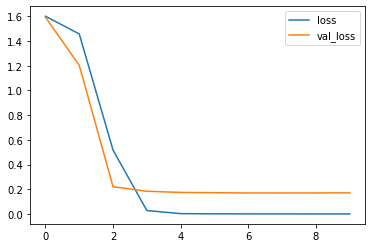

In [38]:
import matplotlib.pyplot as plt

plt.plot(r.history["loss"],label="loss")
plt.plot(r.history["val_loss"],label="val_loss")
plt.legend()
plt.show()

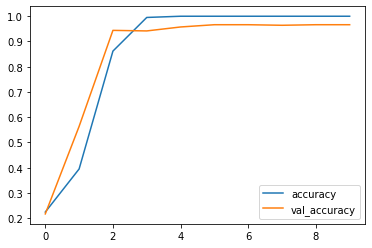

In [39]:
plt.plot(r.history["accuracy"],label="accuracy")
plt.plot(r.history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

In [0]:
model.save("/content/drive/My Drive/Colab Notebooks/NLP mini project/model2.h5")

In [0]:
#---TEST SET EVAL ---------------------------
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP mini project/BBC News Test.csv")

proc_text2 = []
ps = PorterStemmer()
for i in range(len(df_test["Text"])):
  article = re.sub('[^a-zA-Z]',' ',df_test["Text"][i])
  article = article.lower()
  article = article.split()
  article = [ ps.stem(word) for word in article if word not in set(stopwords.words('english'))]
  article = " ".join(article)
  proc_text2.append(article)

df_test["processed_text"] = proc_text2
X_test = tokenizer.texts_to_sequences(df_test["processed_text"])
X_test = pad_sequences(X_test, maxlen=T)

In [0]:
res = model.predict(X_test)

In [0]:
labels = ["business","entertainment","politics","sport","tech"]
preds = []
for c in res:
  idx = np.argmax(c)
  preds.append(labels[idx])

In [0]:
df_test["Category"] = preds

In [0]:
df_new = df_test.drop(columns=["Text","processed_text"])

In [47]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [0]:
df_new.to_csv("/content/drive/My Drive/Colab Notebooks/NLP mini project/sub_3.csv",index=False)